# AMEX Default Prediction

In [ ]:
import numpy as np
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning
# Suppress specific warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning, message="`penalty='none'`has been deprecated")
warnings.filterwarnings("ignore", category=UserWarning, message="Setting penalty=None will ignore the C and l1_ratio parameters")
warnings.filterwarnings("ignore", category=ConvergenceWarning, message="The max_iter was reached which means the coef_ did not converge")

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split


In [117]:
file_path = r'C:\Users\chenl\machine learning\train_data.ftr'

data = pd.read_feather(file_path)


# 1. Project overview:
Data is provide by AMEX, the main task is to use historical data about a customer, which is collected month-by-month (like their spending habits, payment patterns, credit card balances, etc.) to estimate the likelihood that they will fail to repay what they owe on their credit card in the future.

The "target" column has two possible values: "default" (mark as 1) or "no default" (0). Watching the customer's behavior for the next 18 months. If, during those 18 months of observation, the customer fails to make a payment within 120 days (4 months) from the date of their last statement, they are marked as having defaulted (even if they make a payment on the 121st day or anytime after)

# 2. Assumptions & Hypotheses:
The dataset contains aggregated profile features (190 in total) for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

D_* = Delinquency variables
S_* = Spend variables
P_* = Payment variables
B_* = Balance variables
R_* = Risk variables

Assumption: 
- Dataset provided can represente general customer population of AMEX; 
- features available for modeling are relevant and sufficient to predict the target variable;
- numerical data are normalizd, but relationship with target likely be non-linear;

Method:
- It's a classification program, since relationship of feature with target likely be non-linear, decision tree & emsemble learning along likely be more optimal than linear regression models. 
- We will also try boosting, alone with stacking method




# 3. EDA
- 5.5m rows
- 190 feature + 1 target column
- Customer_ID - 458913 unique customers, with different number of statements

In [46]:
# Convert 'S_2' to datetime
data['S_2'] = pd.to_datetime(data['S_2'])
print("unique customer",data["customer_ID"].nunique())
print("miss data in target column?",data["target"].isna().any())

unique customer 458913
miss data in target column? False


# last statement date
- last day of statements fall around march 2018, moniter 18month period for that if any late payment after 120 days of the last statement date
- no significant correlation with prob % of default via dates of last statement
- most null are in Delinquent features, which make sense since delinquent behavior relative minor。

In [47]:
last_s2=data.groupby("customer_ID")["S_2"].last().reset_index()
print(last_s2.describe())
del last_s2

#last statement day default %
last_s = data.groupby('customer_ID').agg({'S_2': 'last', 'target': 'last'}).reset_index()
default_rate = pd.DataFrame(data={'Default': last_s.groupby('S_2')['target'].mean() * 100})
default_rate['Paid'] = (1 - last_s.groupby('S_2')['target'].mean()) * 100
print(default_rate)
del last_s

                                 S_2
count                         458913
mean   2018-03-16 11:24:57.483836928
min              2018-03-01 00:00:00
25%              2018-03-10 00:00:00
50%              2018-03-17 00:00:00
75%              2018-03-24 00:00:00
max              2018-03-31 00:00:00
              Default       Paid
S_2                             
2018-03-01  27.308707  72.691293
2018-03-02  28.290097  71.709903
2018-03-03  27.028444  72.971556
2018-03-04  26.508186  73.491814
2018-03-05  27.031049  72.968951
2018-03-06  26.828266  73.171734
2018-03-07  26.789051  73.210949
2018-03-08  25.864835  74.135165
2018-03-09  25.061956  74.938044
2018-03-10  24.926904  75.073096
2018-03-11  25.535115  74.464885
2018-03-12  25.376979  74.623021
2018-03-13  27.038190  72.961810
2018-03-14  25.942526  74.057474
2018-03-15  25.572223  74.427777
2018-03-16  25.617566  74.382434
2018-03-17  24.891969  75.108031
2018-03-18  25.730652  74.269348
2018-03-19  27.018615  72.981385
2018-03-20 

In [48]:
null_vals = data.isna().sum().sort_values(ascending=False)
print(null_vals[null_vals > 0].head(30))
del null_vals

D_87     5527586
D_88     5525447
D_108    5502513
D_111    5500117
D_110    5500117
B_39     5497819
D_73     5475595
B_42     5459973
D_136    5336752
D_138    5336752
D_137    5336752
D_135    5336752
D_134    5336752
R_9      5218918
B_29     5150035
D_106    4990102
D_132    4988874
D_49     4985917
R_26     4922146
D_76     4908954
D_66     4908097
D_42     4740137
D_142    4587043
D_53     4084585
D_82     4058614
D_50     3142402
B_17     3137598
D_105    3021431
D_56     2990943
S_9      2933643
dtype: int64


118828
340085


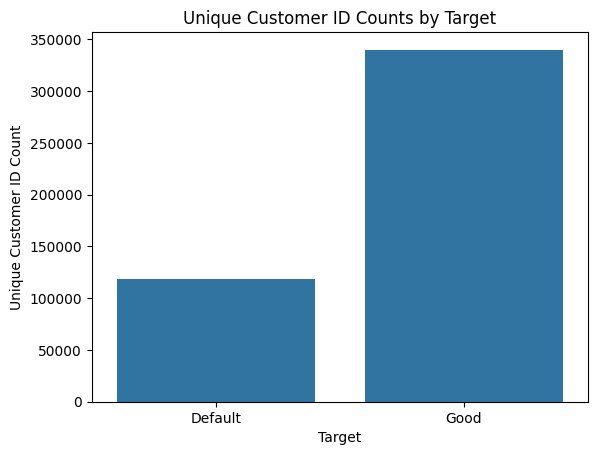

In [49]:
default_df=data[data["target"]==1]
good_df=data[data["target"]==0]
print(default_df["customer_ID"].nunique())
print(good_df["customer_ID"].nunique())

unique_counts = {
    'Dataset': ['Default', 'Good'],
    'Unique_Counts': [
        default_df["customer_ID"].nunique(),
        good_df["customer_ID"].nunique()
    ]
}

df_counts = pd.DataFrame(unique_counts)

sns.barplot(x='Dataset', y='Unique_Counts', data=df_counts)
plt.title('Unique Customer ID Counts by Target')
plt.xlabel('Target')
plt.ylabel('Unique Customer ID Count')
plt.show()

del default_df
del good_df
del df_counts

NOTE:
There are 118828 customer defaulted, while 340085 good customers have not. 
But good customers have been subsampled by a factor of 20; this means that in reality there are 6.8 million good customers. roughly 98 % of the customers are good; while roughly 2 % are bad.

# STATEMENTS count per customer
likely that minor amountof customers with less statement number are due to new joined customers

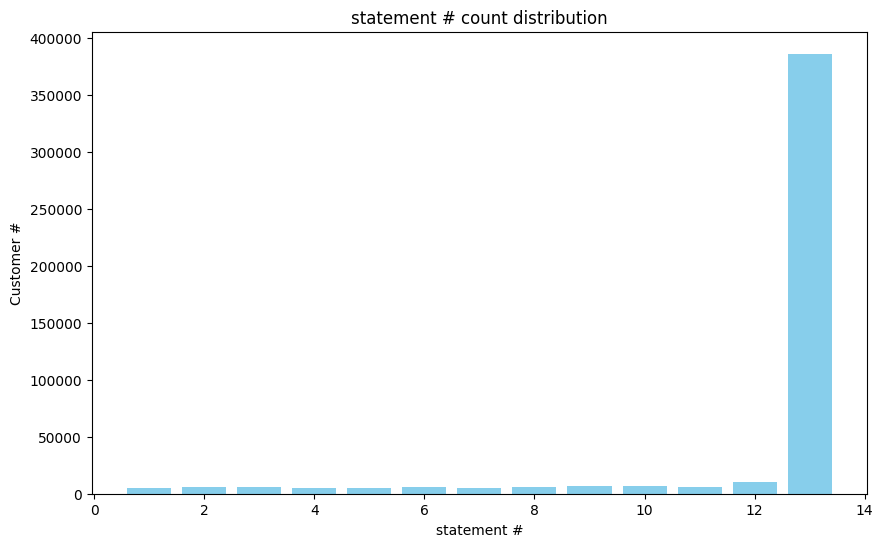

count
13    386034
12     10623
11      5961
10      6721
9       6411
8       6110
7       5198
6       5515
5       4671
4       4673
3       5778
2       6098
1       5120
Name: Train statements per customer, dtype: int64


In [50]:

temp = data.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Train statements per customer')
# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(temp.index, temp, color='skyblue')
plt.xlabel('statement #')
plt.ylabel('Customer #')
plt.title('statement # count distribution')
plt.show()
print(temp)

del temp

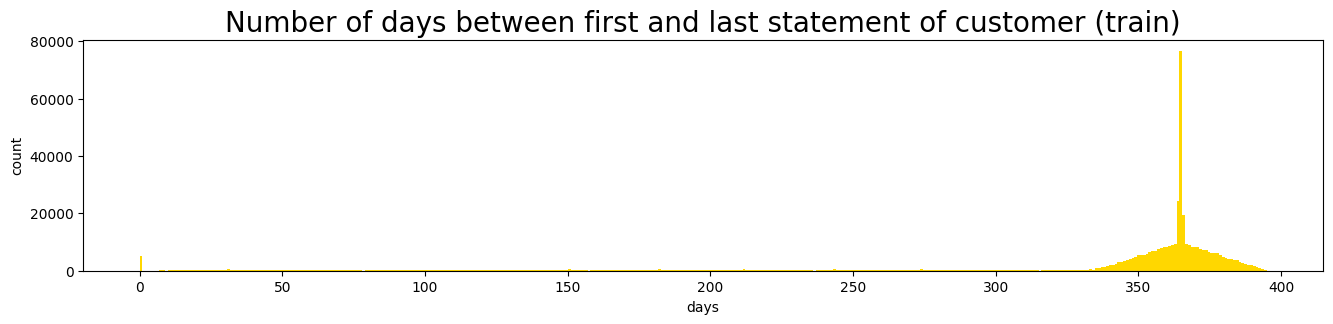

In [51]:
temp = data.S_2.groupby(data.customer_ID).agg(['max', 'min'])
plt.figure(figsize=(16, 3))
plt.hist((temp['max'] - temp['min']).dt.days, bins=400, color='#ffd700')
plt.xlabel('days')
plt.ylabel('count')
plt.title('Number of days between first and last statement of customer (train)', fontsize=20)
plt.show()

del temp

# features data types

In [52]:
all_cols = data.columns.to_list()
cat_cols = data.select_dtypes("category").columns.tolist()
num_cols = data.select_dtypes(include =['float16','int64']).columns.tolist()
num_cols=list(set(data[num_cols]) - {'target'})

Categorical features

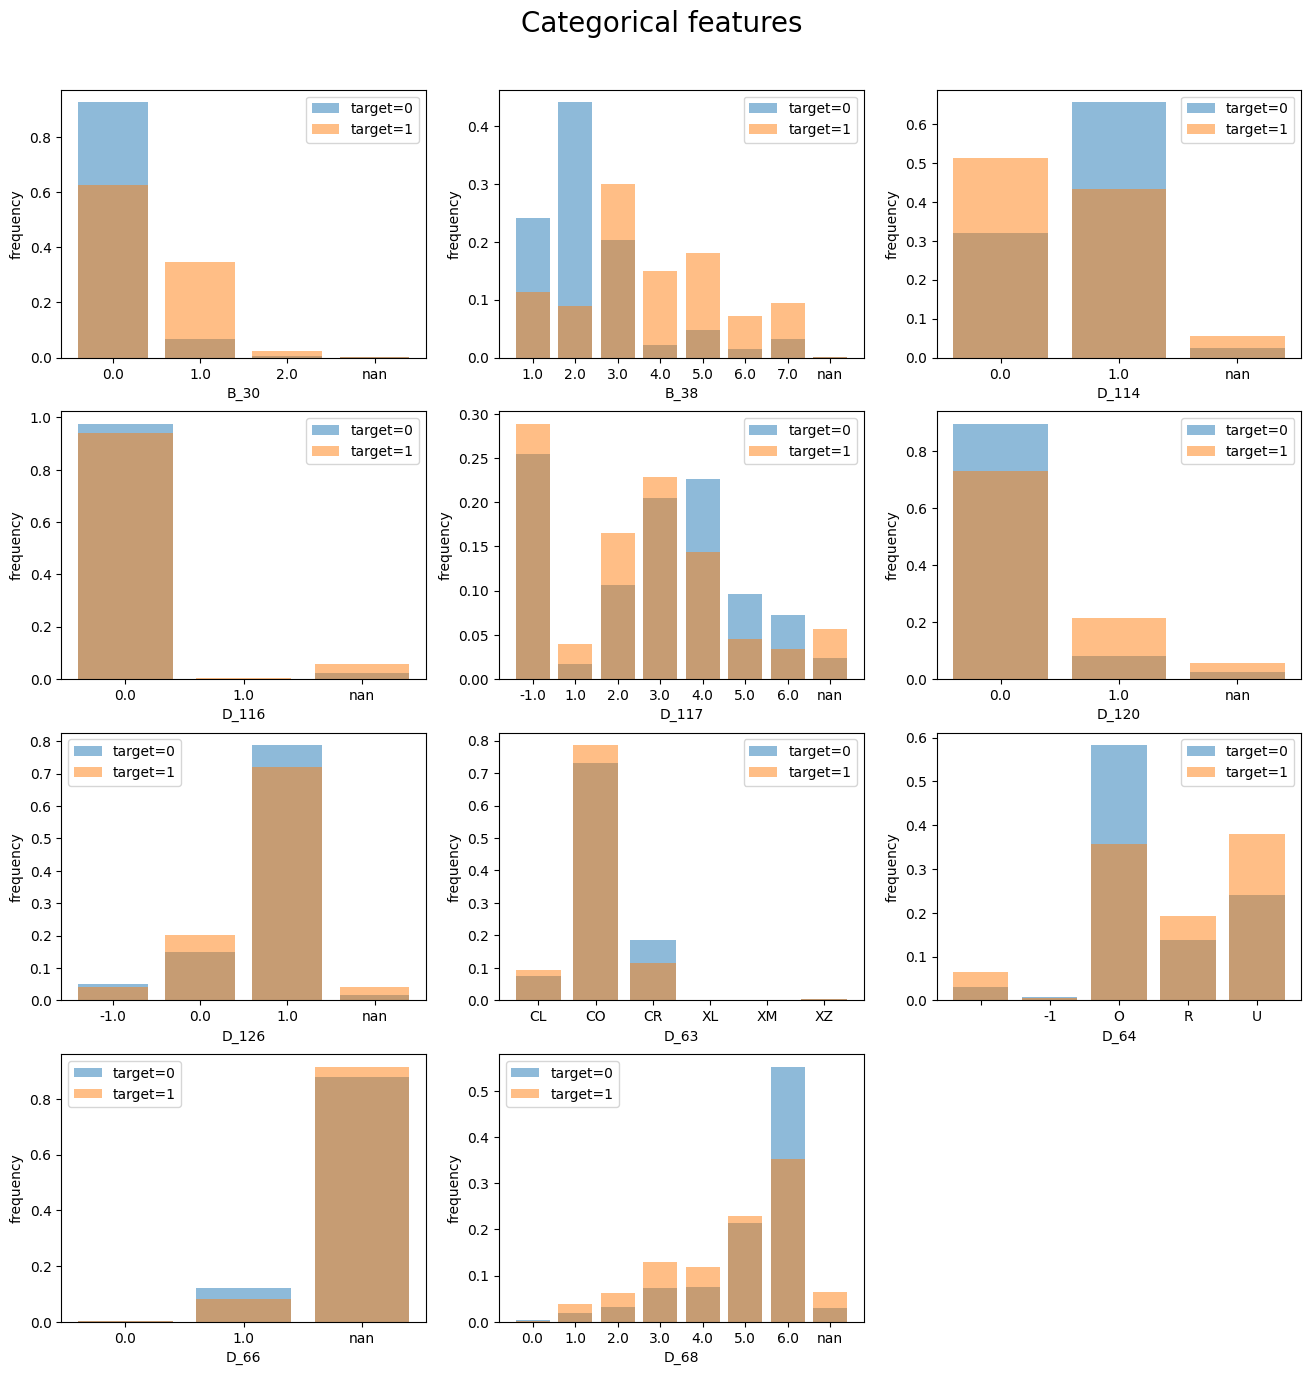

In [53]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
plt.figure(figsize=(16, 16))
for i, f in enumerate(cat_features):
    plt.subplot(4, 3, i+1)
    temp = pd.DataFrame(data[f][data.target == 0].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=0')
    temp = pd.DataFrame(data[f][data.target == 1].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=1')
    plt.xlabel(f)
    plt.ylabel('frequency')
    plt.legend()
    plt.xticks(temp.index, temp.value)
plt.suptitle('Categorical features', fontsize=20, y=0.93)
plt.show()
del temp

Numerical features

Histograms with white space at the left or right end can indicate that the data contain outliers. We have to deal with these outliers. Without further information, we can't figure out if those are real outliers, either the distribution


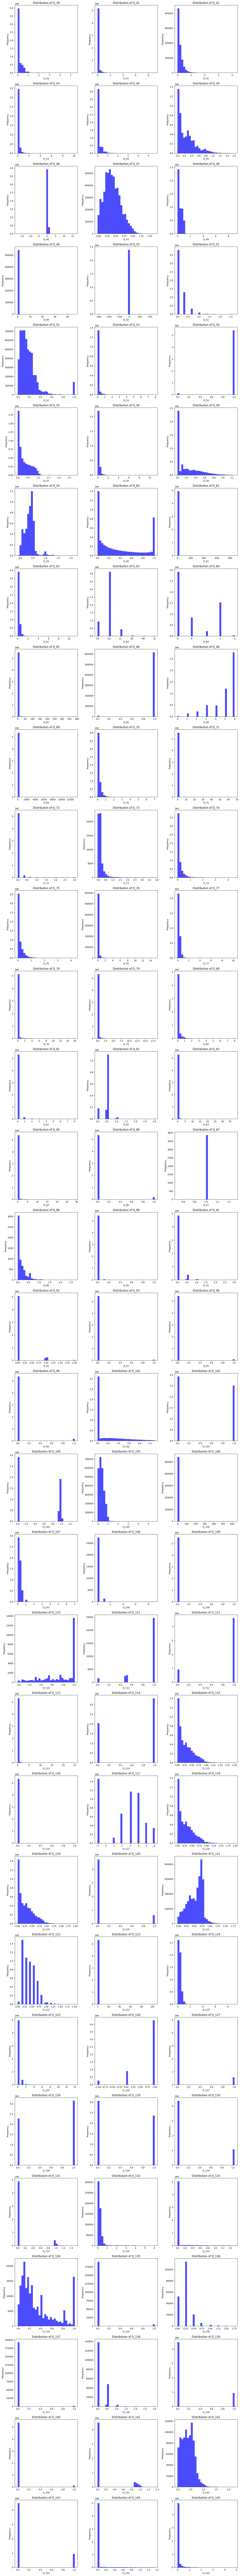

In [54]:
# List of delinquency columns
delinquency_cols = [col for col in data.columns if col.startswith('D_')]

# Plotting histograms for Delinquency variables
plt.figure(figsize=(15, 5 * ((len(delinquency_cols) + 2) // 3)))

for i, col in enumerate(delinquency_cols):
    plt.subplot((len(delinquency_cols) + 2) // 3, 3, i + 1)
    plt.hist(data[col], bins=30, alpha=0.7, color='blue')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

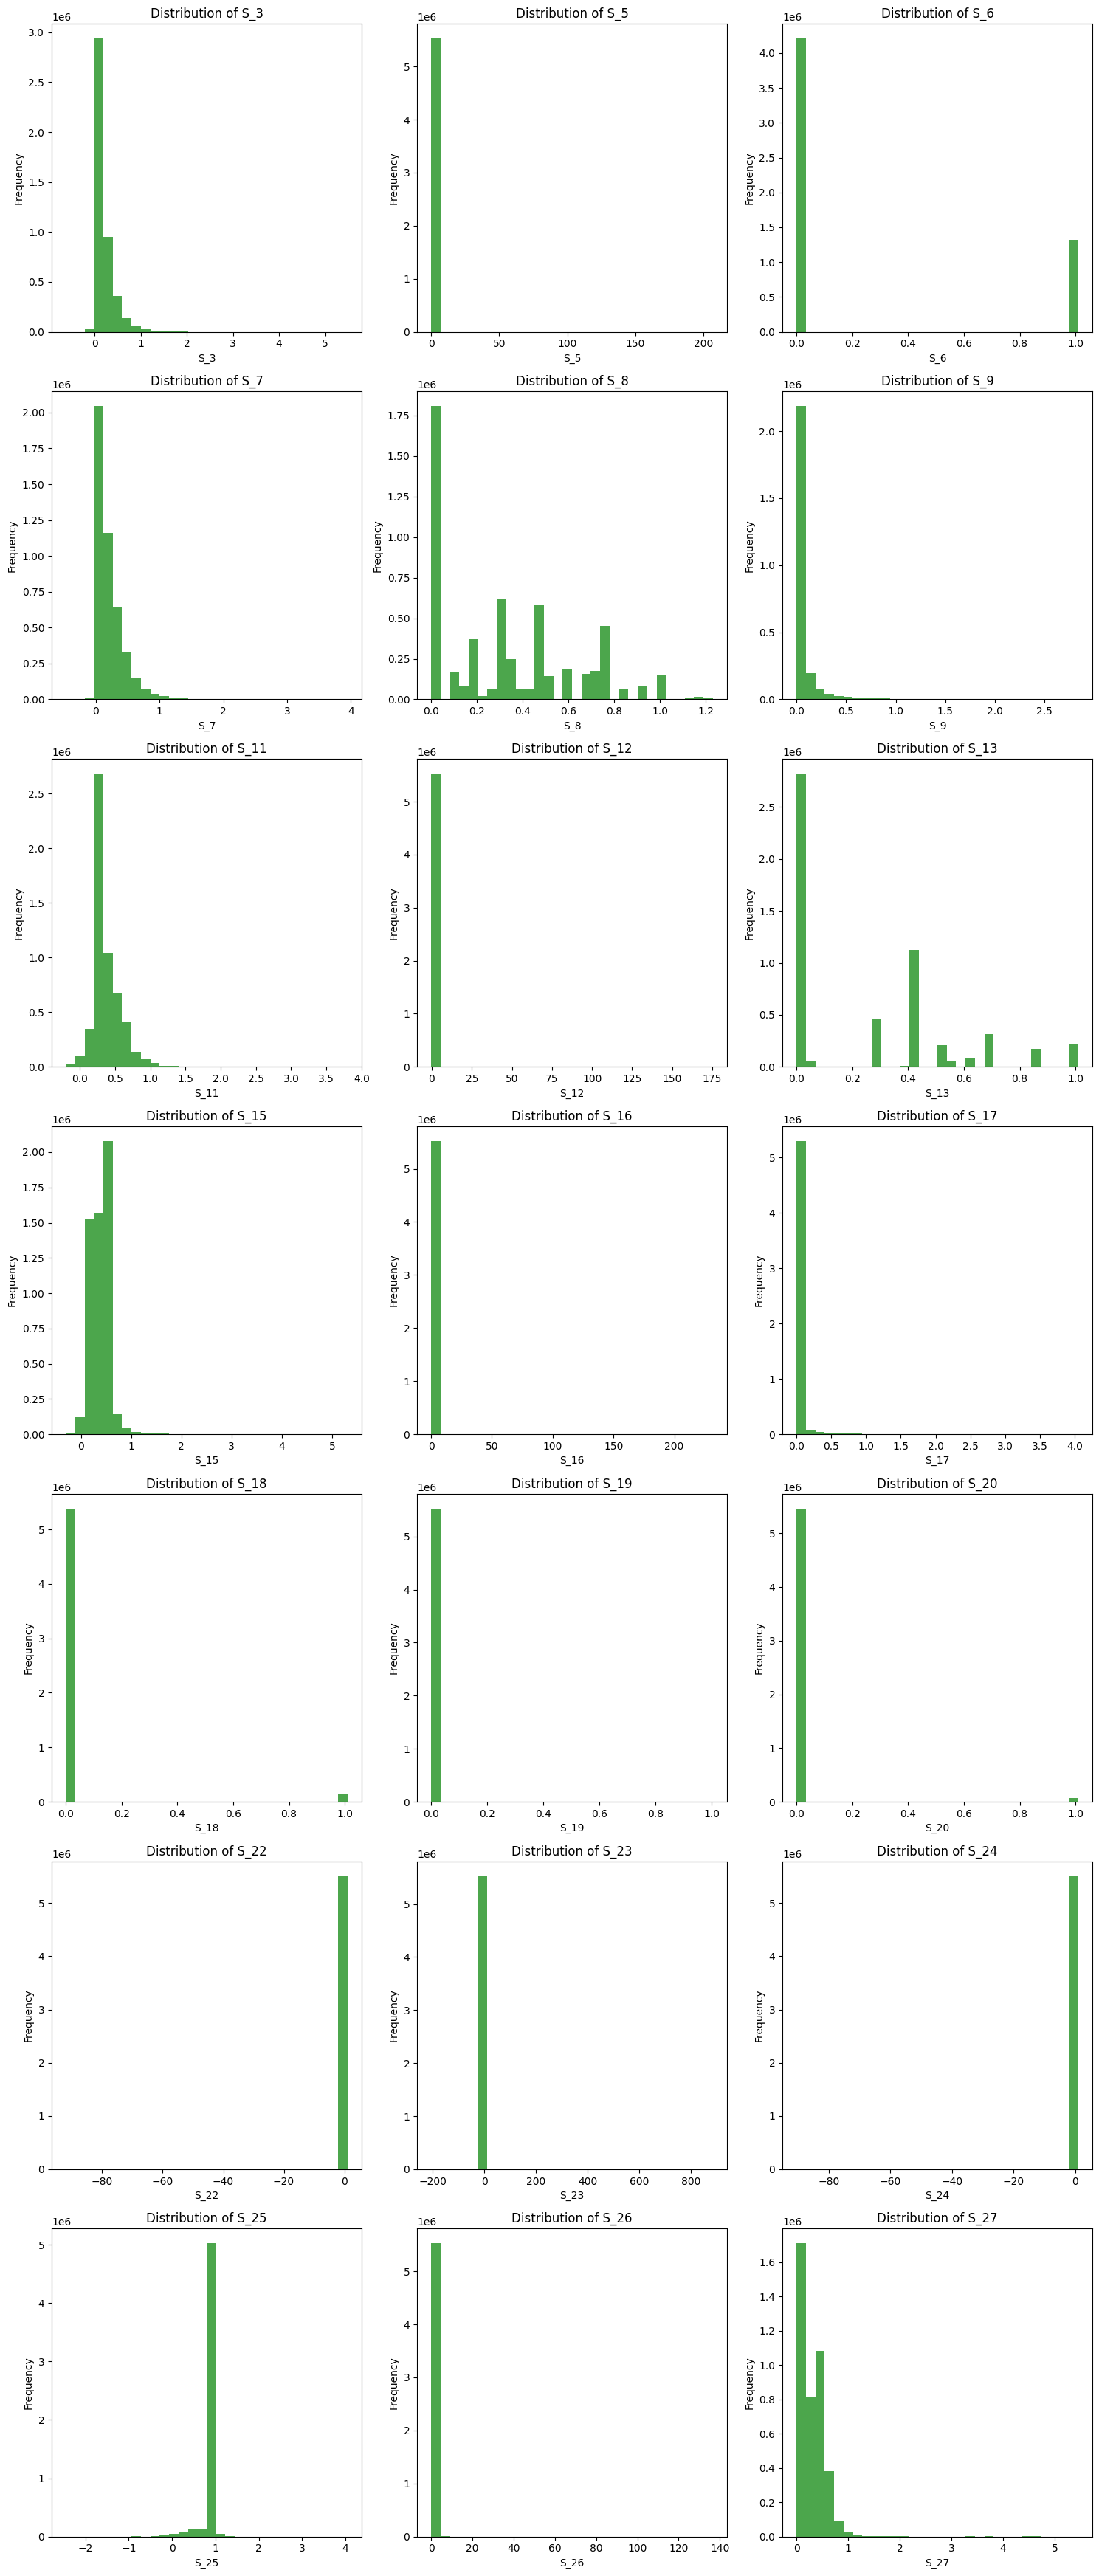

In [55]:
# List of spend columns, exclude S_2 which is statement date
spend_cols = [col for col in data.columns if col.startswith('S_') and col != 'S_2']

# Plotting histograms for Spend variables
plt.figure(figsize=(15, 5 * ((len(spend_cols) + 2) // 3)))

for i, col in enumerate(spend_cols):
    plt.subplot((len(spend_cols) + 2) // 3, 3, i + 1)
    plt.hist(data[col], bins=30, alpha=0.7, color='green')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

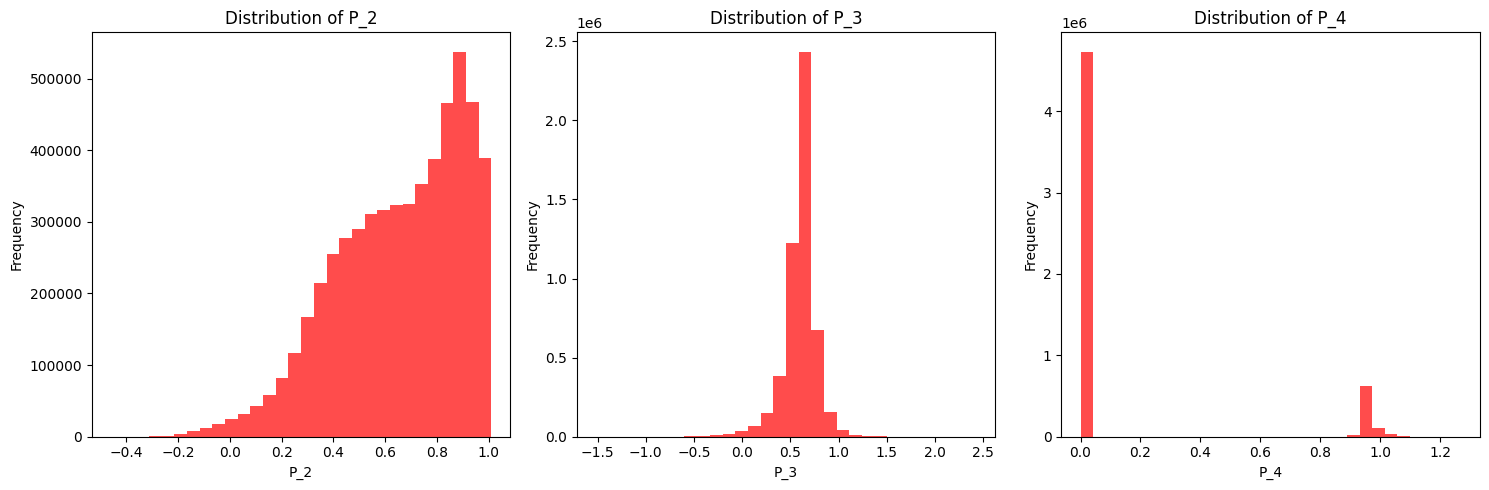

In [56]:
# List of payment columns
payment_cols = [col for col in data.columns if col.startswith('P_')]

# Plotting histograms for Payment variables
plt.figure(figsize=(15, 5 * ((len(payment_cols) + 2) // 3)))

for i, col in enumerate(payment_cols):
    plt.subplot((len(payment_cols) + 2) // 3, 3, i + 1)
    plt.hist(data[col], bins=30, alpha=0.7, color='red')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

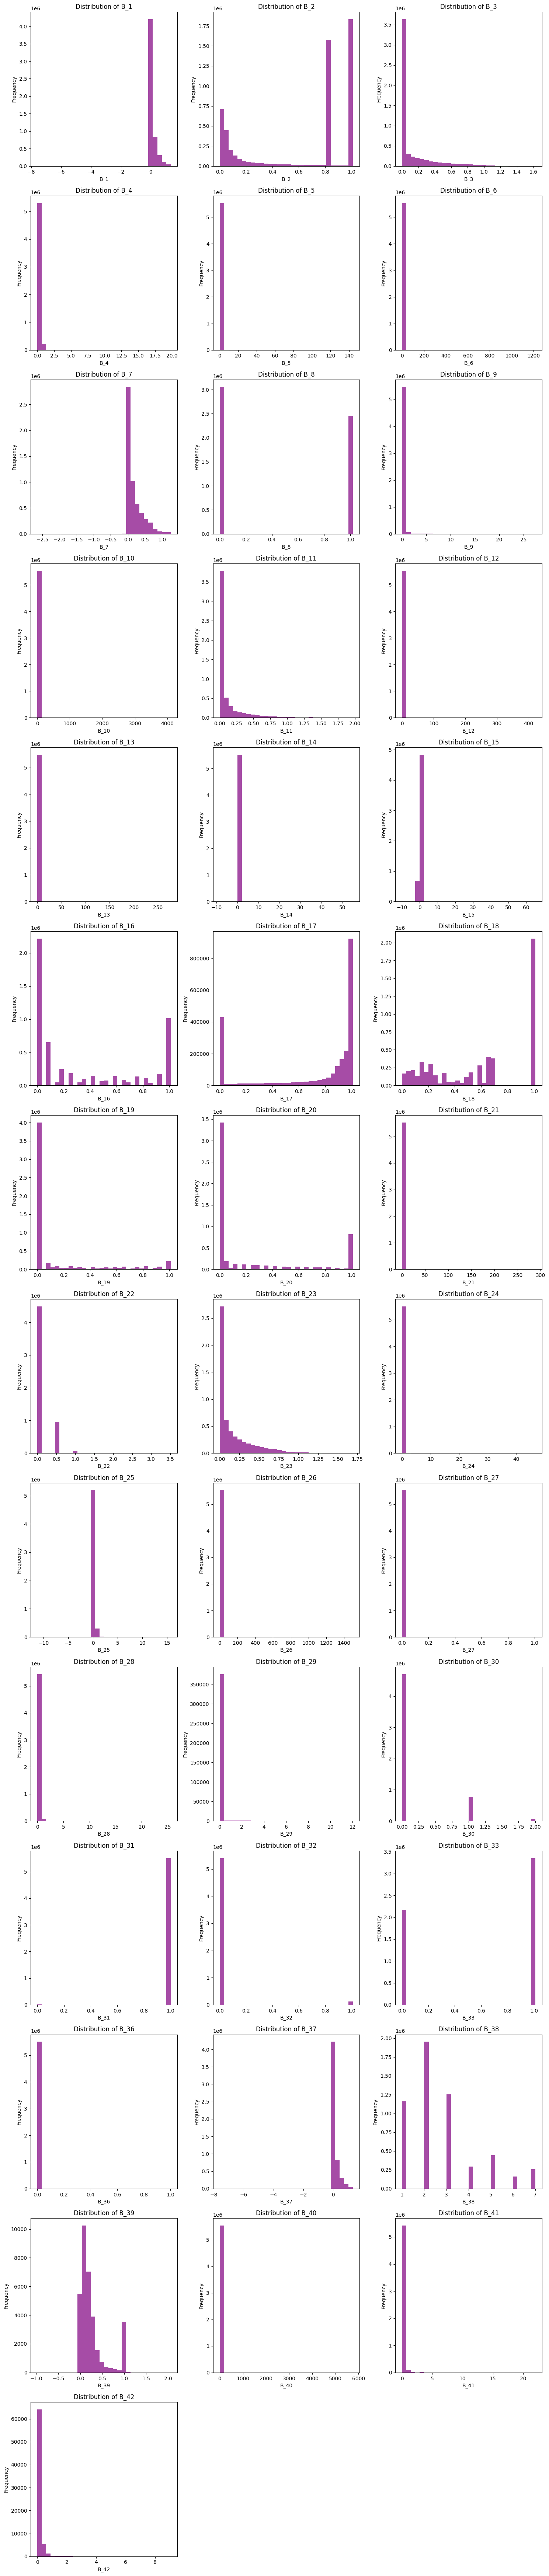

In [57]:
# List of balance columns
balance_cols = [col for col in data.columns if col.startswith('B_')]

# Plotting histograms for Balance variables
plt.figure(figsize=(15, 5 * ((len(balance_cols) + 2) // 3)))

for i, col in enumerate(balance_cols):
    plt.subplot((len(balance_cols) + 2) // 3, 3, i + 1)
    plt.hist(data[col], bins=30, alpha=0.7, color='purple')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {col}')

plt.tight_layout()

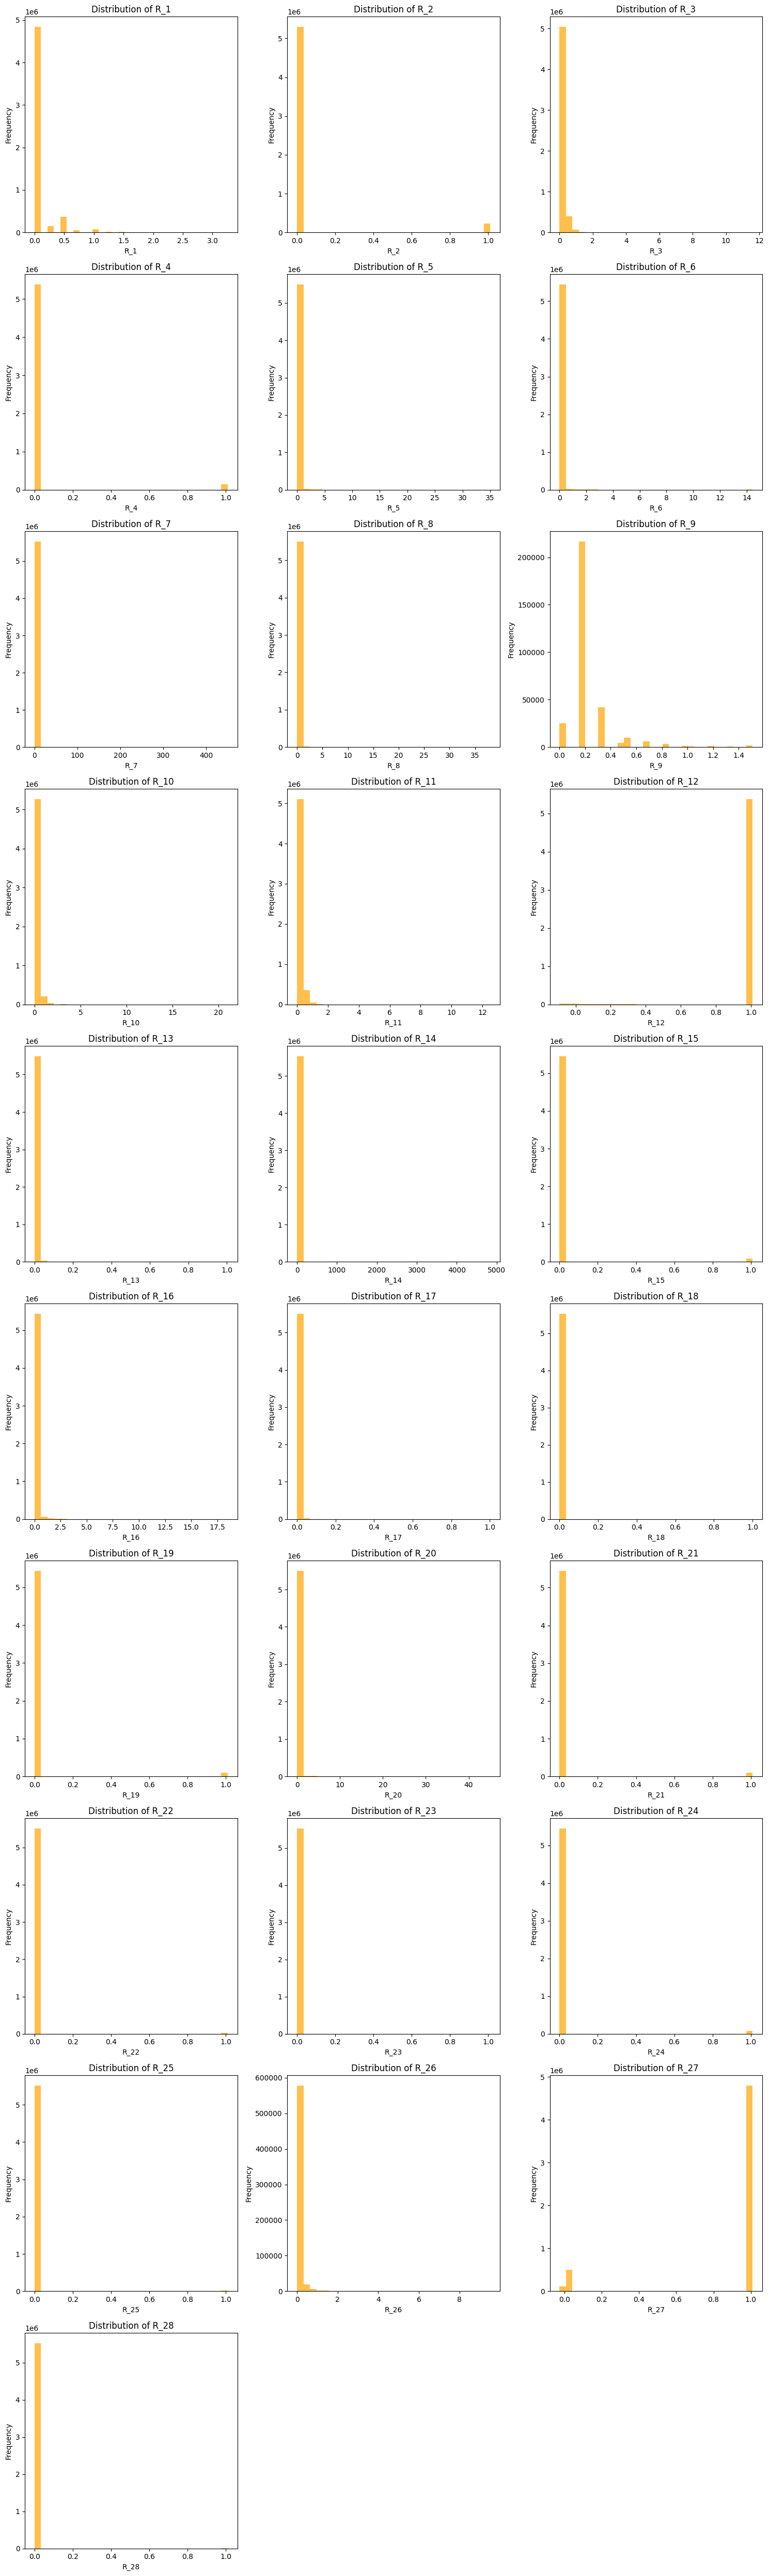

In [58]:
# List of risk columns
risk_cols = [col for col in data.columns if col.startswith('R_')]

# Plotting histograms for Risk variables
plt.figure(figsize=(15, 5 * ((len(risk_cols) + 2) // 3)))

for i, col in enumerate(risk_cols):
    plt.subplot((len(risk_cols) + 2) // 3, 3, i + 1)
    plt.hist(data[col], bins=30, alpha=0.7, color='orange')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

correlation with target

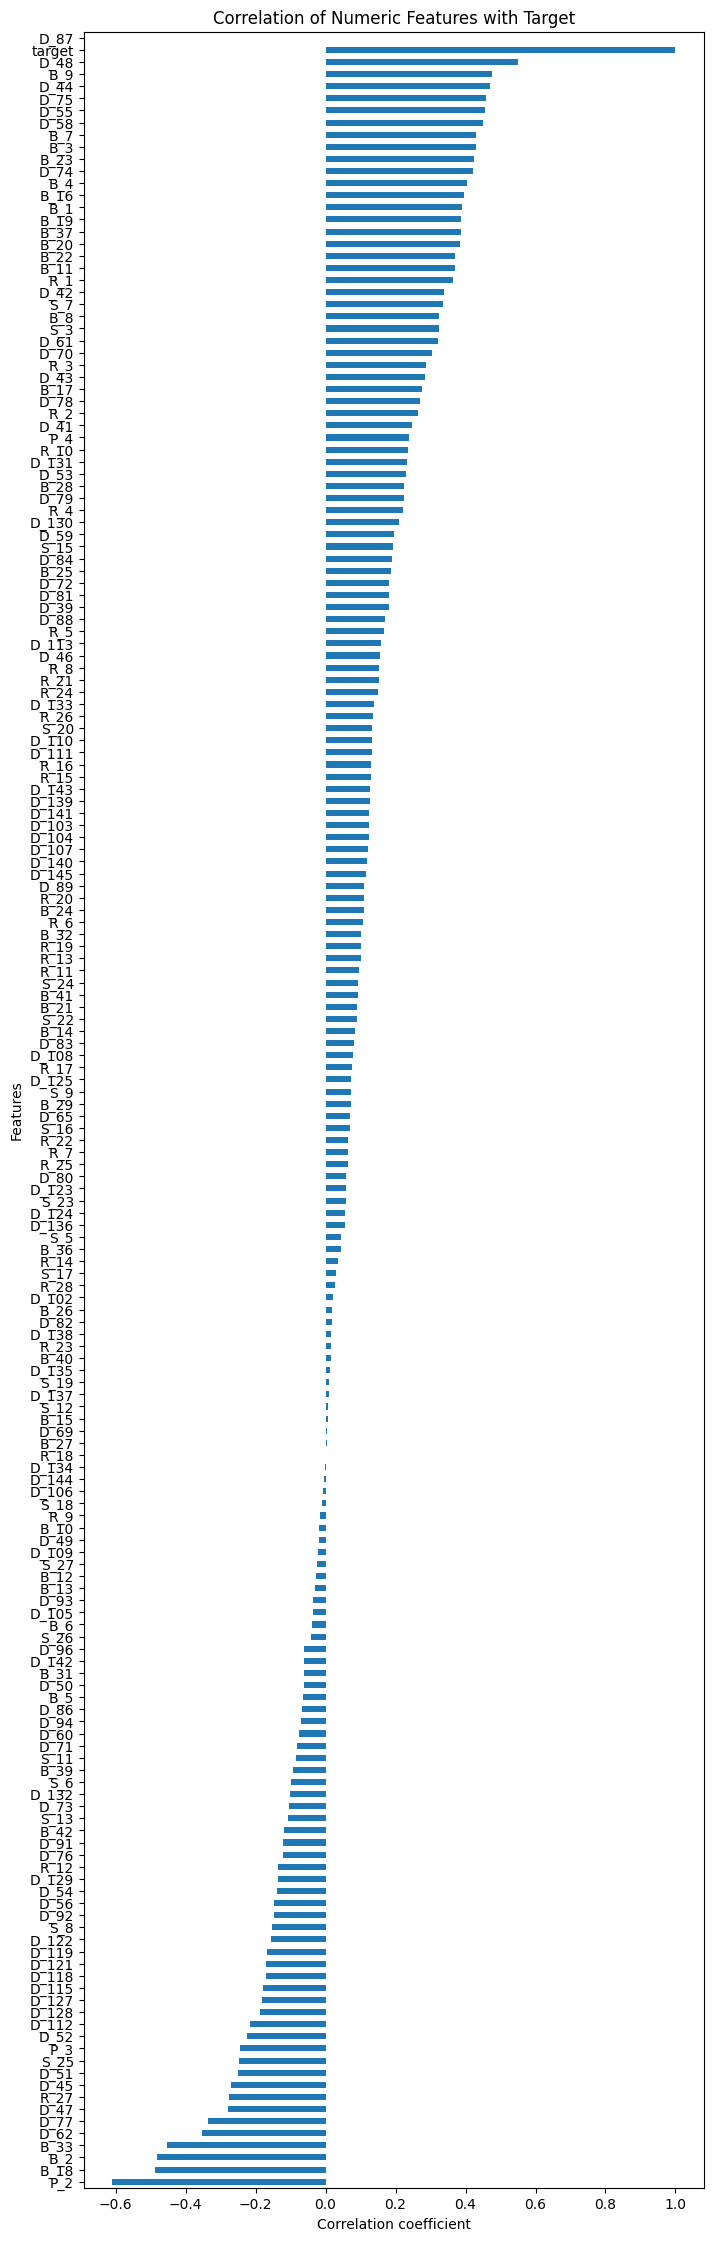

In [59]:
# Calculate correlation of each numeric feature with the target
numeric_cols = data.select_dtypes(include=[np.number]).columns
cor_with_target = data[numeric_cols].corrwith(data['target'])
cor_with_target_sorted = cor_with_target.sort_values(ascending=True)

# Visualize the correlation with the target
plt.figure(figsize=(8, 28))
cor_with_target_sorted.plot(kind='barh')
plt.title('Correlation of Numeric Features with Target')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()

# 4. Data preparation & feature engineering，transform apply
key is to maintain as much original data with least guessing/assumed elements; capture customer behavior patterns

# preprocessing data before data spliting for train and test
- Drop columns with more 30% missing value, some information is just optional for client to provide hence can't make any judgement giving the null value proportion
- delete highly correlated columns
- one-hot encoder for dummy creation

In [60]:
#drop miss columns
miss_to_drop = [column for column in data.columns if (data[column].isnull().sum()/len(data[column])*100) >=30]
data = data.drop(columns = miss_to_drop)
print('number of columns with >= 30% missing value = ', len(miss_to_drop))

number of columns with >= 30% missing value =  31


In [61]:
#drop high correlated columns
temp = data.drop(['target', 'customer_ID', 'S_2'], axis=1)
numeric_cols = temp.select_dtypes(include=[np.number]).columns
temp = temp[numeric_cols]


cor_matrix = temp.corr()
col_core = set()

for i in range(len(cor_matrix.columns)):
    for j in range(i):
        if(cor_matrix.iloc[i, j] > 0.8):
            col_name = cor_matrix.columns[i]
            col_core.add(col_name)

print(col_core)
del temp

#drop high cor columns
data = data.drop(col_core, axis=1)

{'D_118', 'D_75', 'S_7', 'D_141', 'D_107', 'D_104', 'D_131', 'B_11', 'B_23', 'B_18', 'D_119', 'D_143', 'B_20', 'B_33', 'B_13', 'S_24', 'D_61', 'B_15', 'B_37', 'D_55', 'D_74'}


In [62]:
# fulfill null in categorical columns with Unknown and then create dummies
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68']
# Convert columns to 'category' dtype and add 'Unknown' category
for col in cat_features:
    data[col] = data[col].astype('category')
    data[col] = data[col].cat.add_categories('Unknown')
data[cat_features] =data[cat_features].fillna('Unknown')
data= pd.get_dummies(data,columns=cat_features, drop_first=True)
dummy_vars = [col for col in data.columns if any(col.startswith(prefix) for prefix in cat_features)]
print(dummy_vars)

['B_30_1.0', 'B_30_2.0', 'B_30_Unknown', 'B_38_2.0', 'B_38_3.0', 'B_38_4.0', 'B_38_5.0', 'B_38_6.0', 'B_38_7.0', 'B_38_Unknown', 'D_114_1.0', 'D_114_Unknown', 'D_116_1.0', 'D_116_Unknown', 'D_117_1.0', 'D_117_2.0', 'D_117_3.0', 'D_117_4.0', 'D_117_5.0', 'D_117_6.0', 'D_117_Unknown', 'D_120_1.0', 'D_120_Unknown', 'D_126_0.0', 'D_126_1.0', 'D_126_Unknown', 'D_63_CO', 'D_63_CR', 'D_63_XL', 'D_63_XM', 'D_63_XZ', 'D_63_Unknown', 'D_64_-1', 'D_64_O', 'D_64_R', 'D_64_U', 'D_64_Unknown', 'D_68_1.0', 'D_68_2.0', 'D_68_3.0', 'D_68_4.0', 'D_68_5.0', 'D_68_6.0', 'D_68_Unknown']


# first split: 85% train & valiadation, 15% test
apply stratify via the unique customer list， ensure all statements exist for each ID after spliting

In [63]:
target = 'target'
customer_id = 'customer_ID'

customer_targets = data.groupby(customer_id)[target].first().reset_index()

train_customers, final_test_customers = train_test_split(
    customer_targets,
    test_size=0.15,
    random_state=100,
    stratify=customer_targets[target]
)

# Split the original data based on the customer IDs
train = data[data[customer_id].isin(train_customers[customer_id])]
final_test = data[data[customer_id].isin(final_test_customers[customer_id])]

del data
print(train['customer_ID'].nunique())
print(final_test['customer_ID'].nunique())

390076
68837


after split, there are 390k unique customer in training, and 68k in test data set

# Data process after spliting

# imputing na value
1. after spliting to prevent data leakage
2. after exam the distribution, use mode to impute missing data
3. hypothesis is missing value is not randomly distribution
4. imputing instead of simple drop missing data, as there are too many of them and unsure of the distribution.

In [64]:
# miss_columns=['P_2', 'B_2', 'S_3', 'D_41', 'B_3', 'D_43', 'D_44', 'D_45', 'D_46',
#        'D_48', 'B_6', 'B_8', 'D_52', 'P_3', 'D_54', 'D_55', 'B_13', 'D_59',
#        'D_61', 'D_62', 'B_16', 'B_19', 'B_20', 'D_69', 'B_22', 'D_70', 'D_72',
#        'R_7', 'B_25', 'B_26', 'D_78', 'D_79', 'D_80', 'B_27', 'D_81', 'R_12',
#        'D_83', 'R_14', 'D_84', 'R_20', 'D_89', 'D_91', 'S_22', 'S_23', 'S_25',
#        'S_26', 'D_102', 'D_103', 'D_107', 'R_27', 'D_109', 'D_112', 'B_40',
#        'S_27', 'D_113', 'D_115', 'D_118', 'D_121', 'D_122', 'D_123', 'D_124',
#        'D_125', 'D_128', 'D_129', 'B_41', 'D_130', 'D_131', 'D_133', 'D_139',
#        'D_140', 'D_144', 'D_145']
# # Plotting histograms for Delinquency variables
# plt.figure(figsize=(15, 5 * ((len(miss_columns) + 2) // 3)))

# for i, col in enumerate(miss_columns):
#     plt.subplot((len(miss_columns) + 2) // 3, 3, i + 1)
#     plt.hist(train_numeric[col], bins=30, alpha=0.7, color='blue')
#     plt.xlabel(col)
#     plt.ylabel('Frequency')
#     plt.title(f'Distribution of {col}')

# plt.tight_layout()
# plt.show()

In [65]:
exclude_cols = ['target', 'customer_ID', 'S_2']

# Isolate numeric features for imputation
train_numeric = train.drop(columns=exclude_cols)
final_test_numeric = final_test.drop(columns=exclude_cols)

# Identify columns with missing values
missing_cols= train_numeric.columns[train_numeric.isnull().any()]

# Apply mode imputation only to columns with missing values
imputer = SimpleImputer(strategy='most_frequent')
train_numeric[missing_cols] = imputer.fit_transform(train_numeric[missing_cols])
final_test_numeric[missing_cols] = imputer.transform(final_test_numeric[missing_cols])

# Re-integrate non-numeric and target columns
train_numeric[exclude_cols] = train[exclude_cols].reset_index(drop=True)
final_test_numeric[exclude_cols] = final_test[exclude_cols].reset_index(drop=True)

# release memory
del train
del final_test


# aggregation process:
mean for numeric, and count for S_2 column

In [66]:
# Separate the S_2 column and calculate its count for each customer
s2_count = train_numeric.groupby('customer_ID')['S_2'].count().reset_index()
final_s2_count = final_test_numeric.groupby('customer_ID')['S_2'].count().reset_index()

# Aggregate the remaining columns using the mean
train_aggregated_mean =  train_numeric.drop(columns='S_2').groupby('customer_ID').mean().reset_index()
final_test_aggregated_mean = final_test_numeric.drop(columns='S_2').groupby('customer_ID').mean().reset_index()

# Merge the aggregated results back together
train_aggregated = pd.merge(train_aggregated_mean, s2_count, on='customer_ID')
final_test_aggregated = pd.merge(final_test_aggregated_mean, final_s2_count, on='customer_ID')

# Clean up memory
del train_numeric
del final_test_numeric
del train_aggregated_mean
del final_test_aggregated_mean

# 5. modeling
- stratify split

- likely non-linear relationship between features and target
- high dimensionality
- classification problem, use cross valiadation and multiple models to test out the best on

Logistic Regression: simple form as baseline model
es


Decision trule based model, easier to interpretmodels


Randomplicated ensemble decis methodion trees, addresses overfitting through bagging method,effective performance without extensive hyperparameter tuning


LGBM: a boost based method, faster training and lower memory usage compare to forest and boost methods, especailly in large datasets


exclude SVC:  unsure if there are clear margin of separation between classes, no suitable for large datasets sparse data, etc

In [67]:
# Train-test split
X = train_aggregated.drop(columns=['customer_ID','target'])
y = train_aggregated['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

In [100]:
logistic_regression = LogisticRegression(max_iter=1000)

decision_tree = DecisionTreeClassifier()

random_forest = RandomForestClassifier()

lightgbm = lgb.LGBMClassifier()

# mlp = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', alpha=0.0001, learning_rate='adaptive', max_iter=1000)

# 6. model justification:
- Cross-Validation: ensure the model generalizes well to unseen data.
- Regularization: Apply regularization techniques (ridge and lasso regularization) to penalize large coefficients.
- Ensemble Methods
- data were already normalized before provided, but exploring the distribution indicating existing of extreme outliers, hence scaler applied once again to improved Convergence Speed
- Parameter Tuning: Use grid search or random search to find the best combination of hyperparameters.
- stacking method
- use accuracy for performance, as the default & non-default counts is not too imbalance

In [69]:
# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
from sklearn.metrics import accuracy_score
# cross-validation
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=7, scoring='accuracy', n_jobs=-1)
    return np.mean(scores), np.std(scores)

# Evaluate models
log_reg_mean, log_reg_std = evaluate_model(logistic_regression, X_train_scaled, y_train)
dec_tree_mean, dec_tree_std = evaluate_model(decision_tree, X_train_scaled, y_train)
rand_forest_mean, rand_forest_std = evaluate_model(random_forest, X_train_scaled, y_train)
lgbm_mean, lgbm_std = evaluate_model(lightgbm, X_train_scaled, y_train)

# Print cross-validation accuracy result
print(f"Logistic Regression - CV Accuracy: {log_reg_mean:.4f} ± {log_reg_std:.4f}")
print(f"Decision Tree - CV Accuracy: {dec_tree_mean:.4f} ± {dec_tree_std:.4f}")
print(f"Random Forest - CV Accuracy: {rand_forest_mean:.4f} ± {rand_forest_std:.4f}")
print(f"LightGBM - CV Accuracy: {lgbm_mean:.4f} ± {lgbm_std:.4f}")

Logistic Regression - CV Accuracy: 0.7423 ± 0.0000
Decision Tree - CV Accuracy: 0.6122 ± 0.0032
Random Forest - CV Accuracy: 0.7421 ± 0.0001
LightGBM - CV Accuracy: 0.7423 ± 0.0000


# training data accuracy  - single model
Logistic Regression - CV Accuracy: 0.7423 ± 0.0000

Decision Tree - CV Accuracy: 0.6116 ± 0.0027

Random Forest - CV Accuracy: 0.7422 ± 0.0001

LightGBM - CV Accuracy: 0.7423 ± 0.0000


# # Valiadation dateset accuracy - single model result

In [71]:
# Fit each model on the entire training set
logistic_regression.fit(X_train_scaled, y_train)
decision_tree.fit(X_train_scaled, y_train)
random_forest.fit(X_train_scaled, y_train)
lightgbm.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_log_reg = logistic_regression.predict(X_test_scaled)
y_pred_dec_tree = decision_tree.predict(X_test_scaled)
y_pred_rand_forest = random_forest.predict(X_test_scaled)
y_pred_lgbm = lightgbm.predict(X_test_scaled)

# Calculate and print accuracy
def print_accuracy(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy for {model_name}: {accuracy:.4f}")

# Print accuracy for each model
print_accuracy(y_test, y_pred_log_reg, "Logistic Regression")
print_accuracy(y_test, y_pred_dec_tree, "Decision Tree")
print_accuracy(y_test, y_pred_rand_forest, "Random Forest")
print_accuracy(y_test, y_pred_lgbm, "LightGBM")

[LightGBM] [Info] Number of positive: 77219, number of negative: 222465
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34110
[LightGBM] [Info] Number of data points in the train set: 299684, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.257668 -> initscore=-1.058124
[LightGBM] [Info] Start training from score -1.058124
Accuracy for Logistic Regression: 0.7423
Accuracy for Decision Tree: 0.6136
Accuracy for Random Forest: 0.7421
Accuracy for LightGBM: 0.7423


# valiadation data accuracy - single model
Logistic Regression - CV Accuracy: 0.74230

Decision Tree - CV Accuracy: 0.6136027

Random Forest - CV Accuracy: 0.7421

LightGBM - CV Accuracy: 0.7423

# Test dataset accuracy - single model
- LOG and lGBM are still the top proformer

In [78]:
x_final_test=final_test_aggregated.drop(columns=['customer_ID','target'])
y_final_test=final_test_aggregated["target"]

In [79]:
y_pred_log_reg = logistic_regression.predict(x_final_test)
y_pred_dec_tree = decision_tree.predict(x_final_test)
y_pred_rand_forest = random_forest.predict(x_final_test)
y_pred_lgbm = lightgbm.predict(x_final_test)
# Calculate and print accuracy
def print_accuracy(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy for {model_name}: {accuracy:.4f}")

# Print accuracy for each model
print_accuracy(y_final_test, y_pred_log_reg, "Logistic Regression")
print_accuracy(y_final_test, y_pred_dec_tree, "Decision Tree")
print_accuracy(y_final_test, y_pred_rand_forest, "Random Forest")
print_accuracy(y_final_test, y_pred_lgbm, "LightGBM")

Accuracy for Logistic Regression: 0.7361
Accuracy for Decision Tree: 0.6328
Accuracy for Random Forest: 0.3805
Accuracy for LightGBM: 0.7453


# conclusion
Logistic regression and lightGBM performance are consistent between train and valiadation datasets. 

The Random Forest with default parameters may experience overfiting as the valiadation accuracy is dramaticlly lower than training dataset.

# tuning - ran in kaggle 

In [ ]:
# param_grid_logistic_regression = {
#     'penalty': ['l1', 'l2','none'],
#     'C': [0.01, 0.1,1,10,100],
#     'solver': ['liblinear', 'saga'],
#     'max_iter': [300,500]
# }

# # Perform Grid Search
# grid_search_logistic_regression = GridSearchCV(logistic_regression, param_grid_logistic_regression, cv=7, scoring='accuracy', n_jobs=-1)
# grid_search_logistic_regression.fit(X_train, y_train)

# # Print best parameters and best score
# print(f"Best parameters for Logistic Regression: {grid_search_logistic_regression.best_params_}")
# print(f"Best cross-validation balanced accuracy: {grid_search_logistic_regression.best_score_}")

In [ ]:
# param_grid_lightgbm = {
#         'n_estimators': [100, 200],
#         'max_depth': [10, 20, 30],
#         'learning_rate': [0.001,0.01,0.1],
#         'num_leaves': [30, 60,100],
#         'min_child_samples': [20, 30],
#         'reg_alpha': [0.0, 0.1,0.3],# L1 regularization
#         'reg_lambda': [0.0, 0.1,0.3], # L2 regularization 
#         'device': ['gpu']  # Use GPU
# }

# # Perform Grid Search
# grid_search_lightgbm = GridSearchCV(lightgbm, param_grid_lightgbm, cv=7, scoring='accuracy', n_jobs=-1)
# grid_search_lightgbm.fit(X_train, y_train)

# # Best parameters and score
# print(f"Best parameters for LightGBM: {grid_search_lightgbm.best_params_()}")
# print(f"Best cross-validation balanced accuracy: {grid_search_lightgbm.best_score_()}")

# models paramaters after tuning & final test set accuracy
- pick 2 best models, Logistic & LGBM, use parameters from tuning 

In [107]:

logistic = LogisticRegression(
    penalty='l1',
    C=100,
    solver='liblinear',
    max_iter=1000
)

lightgbm = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=20,
    learning_rate=0.001,
    num_leaves=30,
    reg_alpha=0.1, #L1 regularization
    reg_lambda=0.1 #L2 regularization
)

logistic.fit(X_train_scaled, y_train)
lightgbm.fit(X_train_scaled, y_train)


[LightGBM] [Info] Number of positive: 77219, number of negative: 222465
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.190523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34110
[LightGBM] [Info] Number of data points in the train set: 299684, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.257668 -> initscore=-1.058124
[LightGBM] [Info] Start training from score -1.058124


LGBMClassifier(learning_rate=0.001, max_depth=20, n_estimators=200,
               num_leaves=30, reg_alpha=0.1, reg_lambda=0.1)

In [108]:
# Predict on the final test set
y_pred_log= logistic.predict(x_final_test)
y_pred_lgbm = lightgbm.predict(x_final_test)

test_accuracy = accuracy_score(y_final_test, y_pred_log)
print(f"Accuracy for logistic Classifier: {test_accuracy:.4f}")
test_accuracy = accuracy_score(y_final_test, y_pred_lgbm)
print(f"Accuracy for lightgbm Classifier: {test_accuracy:.4f}")


Accuracy for logistic Classifier: 0.6692
Accuracy for lightgbm Classifier: 0.7457


# feature importance

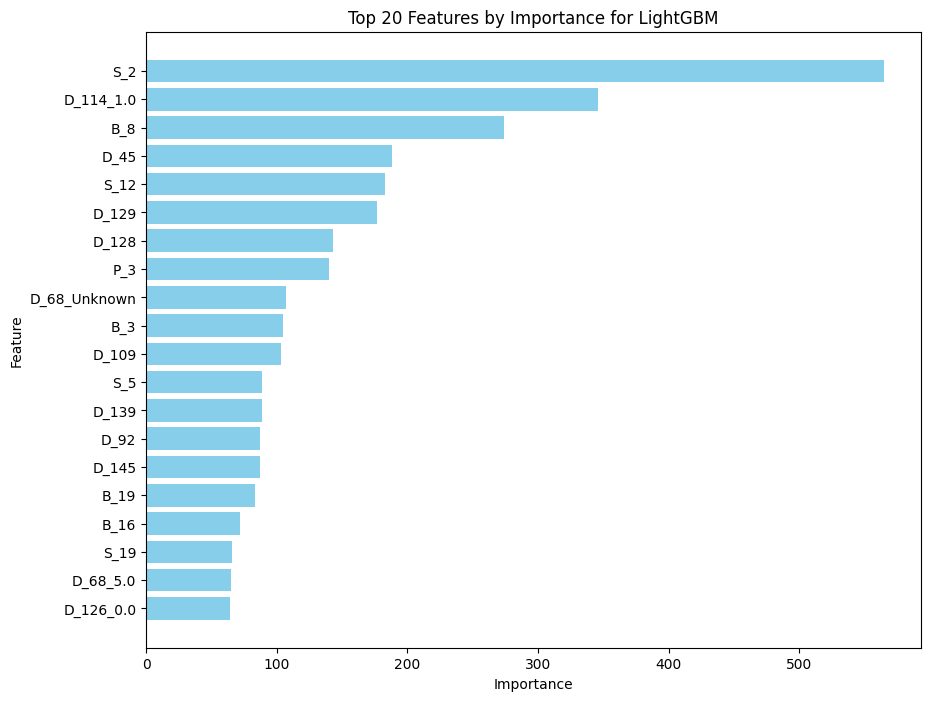

In [99]:
feature_importance_lgbm = lightgbm.feature_importances_

feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'Feature {i}' for i in range(X_train.shape[1])]

df_feature_importance_lgbm = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance_lgbm
}).sort_values(by='Importance', ascending=False)

# Plot the top 20 features by importance
top_20_features = df_feature_importance_lgbm.head(20)

plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Features by Importance for LightGBM')
plt.gca().invert_yaxis()
plt.show()

# stacking with 2 best models & predict final test dataset

In [114]:
#log as estimator
estimators = [
    ('log_reg', logistic),
    ('lgbm', lightgbm)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000)
)

stacking_clf.fit(X_train_scaled, y_train)

#accuracy calculation
y_pred_stack=stacking_clf.predict(x_final_test)

test_accuracy = accuracy_score(y_final_test, y_pred_stack)
print(f"Accuracy for Stacking Classifier: {test_accuracy:.4f}")

[LightGBM] [Info] Number of positive: 77219, number of negative: 222465
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34110
[LightGBM] [Info] Number of data points in the train set: 299684, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.257668 -> initscore=-1.058124
[LightGBM] [Info] Start training from score -1.058124
[LightGBM] [Info] Number of positive: 61775, number of negative: 177972
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34099
[LightGBM] [Info] Number of data points in the train set: 239747, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.257667 -> initscore=-1.058127
[LightGBM] [Info] Start training from score -1.058127
[Lig

In [86]:
#MLP as estimator
estimators = [
    ('log_reg', logistic),
    ('lgbm', lightgbm)
]

mlp = MLPClassifier(
    hidden_layer_sizes=(50, 50),
    activation='relu', #choose for application in binary classification question
    alpha=0.0001, #Use L2 to reduce overfitting but keep all features in the model.
    learning_rate='adaptive', #optimization tech for its easy implement, and scalable
    max_iter=1000
)

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=mlp
)

stacking_clf.fit(X_train_scaled, y_train)

#accuracy calculation
y_pred_stack=stacking_clf.predict(x_final_test)

test_accuracy = accuracy_score(y_final_test, y_pred_stack)
print(f"Accuracy for Stacking Classifier: {test_accuracy:.4f}")

[LightGBM] [Info] Number of positive: 77219, number of negative: 222465
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34110
[LightGBM] [Info] Number of data points in the train set: 299684, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.257668 -> initscore=-1.058124
[LightGBM] [Info] Start training from score -1.058124
[LightGBM] [Info] Number of positive: 61775, number of negative: 177972
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34099
[LightGBM] [Info] Number of data points in the train set: 239747, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.257667 -> initscore=-1.058127
[LightGBM] [Info] Start training from score -1.058127
[Lig

# 7. Results and insight

model result
- Logistic model and LGBM model perform best in train&valiadation datasets, during both plain base single model and hypertuning parameters, achieving 75% accuracy
- complexity and size of data may have result in the logistic regression failing converge
- Testing the holdout data: accuracy of Logistic regression fell to 66% while LGBM stay at 75% (indicating less overfiting issue in LGBM)
- stacking both model didn't achieve better result compare to single model

 
feature importance
- the feature importance indicating the top important features in LGBM algorithm, and the S_2 which is the amount of statement (symbol for length of being the card holders) came to the top.
- following features also showing significant higher importance than other features (D114 B8 D45 S12 D129 D128 P3). 
- According to earlier distribution graph, features D114, D45, D129,D128 and B8 seems like binary feature, while features P3 and S12 looks like continous numerical values
- suprise fact: none of the Risk features show up in the top 20 important features, the risk features supposed to explicitly indicating risk level of customers. 

# 8. future improvement

Data exploration and process

- Discover more data pattern, each features seems to have different distribution pattern and should received different standardizing methods

- Impement smarter impute options, such as KNN, instead of assuming the mode or mean would can represent the missing value rows. However, this practice require higher memory/computation, also perhaps exam each feature to understand what’s better imputation method for eachh
- Try multiple aggregation before fitting the model (such as "last statement - average" and mixing the aggregation method for each columns), instead the simple average of each unique ID, this part should better caputure customer behaviors for analysis

Modeling
- Sequency data analysis, apply RNN and time series methods to capture evolving customer behaviors pattern
- with higher computational power, performing better hypertuning for optimal parameters
- choose performance measuring method to better suit the business context
- the fact that hypertuning didn't improve much tells that there may be some issues before modeling processe)
